In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
def get_clean_data(df_original):
    weekday_dict = {
        0:'Wd', 1:'Wd', 2:'Wd', 3:'Wd', 4:'Wd', 5:'F', 6:'F' 
    }
    
    df = df_original.copy(deep=True)
    df['date'] =  pd.to_datetime(df['datetime'].apply(lambda x: x[:10]), format='%Y-%m-%d')
    df['year'] = df['date'].dt.year
    df['time'] = pd.to_datetime(df['datetime'].apply(lambda x: x[:19])).dt.time
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['datetime'].apply(lambda x: x[11:13]).astype(int)
    df['minute'] = df['datetime'].apply(lambda x: x[14:16]).astype(int)
    df['weekday'] = df['date'].dt.dayofweek
    df.replace({'weekday':weekday_dict}, inplace=True)
    df['season'] = np.where(df['month'].isin(list(range(4,10))), 'summer', 'winter')
    df['date_hour'] = df.apply(lambda x: datetime.datetime.combine(x['date'], x['time']), axis=1)
    df.set_index('date_hour', inplace=True)
    df = df[df.index < '2017']
    clean_df = df[['date', 'year', 'month', 'season', 'day','weekday','time', 'hour', 'minute', 'value']]
    clean_df = clean_df[~clean_df.index.duplicated()]
    clean_df['hour'] = np.where(clean_df['hour'].isin(np.arange(9,23)), 'Peak', 'off_peak')
    #clean_df['value'] = np.log1p(clean_df['value'])
    
    return clean_df

### df with secondary band, spot price and demand 

In [3]:
raw_band_price = pd.read_csv('export_PrecioBandaDeRegulaciónSecundaria_2017-01-15_19-11.csv', encoding='latin1', delimiter=';')
band_price = get_clean_data(raw_band_price)
band_price = band_price.rename(columns={'value':'band'})

In [4]:
raw_spot_price = pd.read_csv('export_PrecioMercadoSPOTDiario_2017-02-02_09-47.csv', encoding='latin1', delimiter=';')
raw_spot_price = raw_spot_price[raw_spot_price['geoid'] == 3]
spot_price = get_clean_data(raw_spot_price)
spot_price = spot_price.rename(columns={'value':'spot'})

In [5]:
raw_demand = pd.read_csv('export_DemandaProgramada_2017-02-02_09-45.csv', encoding='latin1', delimiter=';')
demand = get_clean_data(raw_demand)
demand = demand.rename(columns={'value':'demand'})

In [6]:
spot_band_demand = band_price.merge(spot_price[['spot']], how='left', left_index=True, right_index=True)
spot_band_demand = spot_band_demand.merge(demand[['demand']], how='left', left_index=True, right_index=True)

In [7]:
spot_band_demand = spot_band_demand[['hour', 'weekday', 'season', 'spot','demand', 'band']]

In [8]:
for feature in ['hour', 'weekday', 'season']:
    spot_band_demand[pd.get_dummies(spot_band_demand[feature], drop_first=True).columns.tolist()] = pd.get_dummies(spot_band_demand[feature], drop_first=True)

In [9]:
spot_band_demand['demand+1'] = spot_band_demand['demand'].shift(periods=-1)
spot_band_demand['band-24'] = spot_band_demand['band'].shift(periods=24)
spot_band_demand.dropna(subset=['demand+1', 'band-24'], inplace=True)

### Preprocessing for Decision Tree

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import tree as tree_m
from sklearn.tree import export_graphviz
import graphviz

In [46]:
#Set features and output
X = spot_band_demand.drop(labels=['hour', 'weekday','season', 'band'], axis=1).values
Y = spot_band_demand['band'].values

In [47]:
spot_band_demand.drop(labels=['hour', 'weekday','season', 'band'], axis=1).corr()

,spot,demand,off_peak,Wd,winter,demand+1,band-24
spot,1.000000,0.439178,-0.278173,0.236085,-0.034434,0.418266,-0.293524
demand,0.439178,1.000000,-0.663151,0.390982,0.082227,0.950706,-0.304060
off_peak,-0.278173,-0.663151,1.000000,0.000285,-0.000181,-0.621351,0.298453
Wd,0.236085,0.390982,0.000285,1.000000,-0.003514,0.396874,-0.031628
winter,-0.034434,0.082227,-0.000181,-0.003514,1.000000,0.082313,0.135029
demand+1,0.418266,0.950706,-0.621351,0.396874,0.082313,1.000000,-0.286607
band-24,-0.293524,-0.304060,0.298453,-0.031628,0.135029,-0.286607,1.000000


In [48]:
features_list = spot_band_demand.drop(labels=['hour', 'weekday','season', 'band'], axis=1).columns.tolist()

In [49]:
#Split data set into train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, 
                                                    test_size=0.2, random_state=100)

### Randomized Search CV

In [15]:
params = {
    'criterion':['mse'],
    'splitter':['best','random'],
    'max_features':['auto','log2', 'sqrt'],
    'max_depth':np.arange(2,21), 'min_samples_split':np.linspace(50, 1000, 200).astype(int),
    'min_samples_leaf': np.linspace(200, 2500, 50).astype(int), 'max_leaf_nodes': np.linspace(10,180, 40).astype(int)
}

In [16]:
#Random search, set up tree and cross-validation
tree = DecisionTreeRegressor()
kf = KFold(n_splits=5)

#Randomized Search CV for tree
random_search = RandomizedSearchCV(tree, param_distributions=params, n_jobs=-1, n_iter=350,
                                scoring='neg_mean_squared_error', cv=list(kf.split(x_train,y_train)), random_state=0)

In [17]:
random_search.fit(x_train, y_train);

In [18]:
best_params = random_search.cv_results_['params'][np.flatnonzero(random_search.cv_results_['rank_test_score']==1)[0]]
print(best_params)

{'criterion': 'mse', 'min_samples_split': 408, 'min_samples_leaf': 293, 'max_leaf_nodes': 140, 'max_depth': 6, 'splitter': 'best', 'max_features': 'auto'}


In [19]:
tree.set_params(**best_params, random_state=0)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features='auto',
           max_leaf_nodes=140, min_impurity_split=1e-07,
           min_samples_leaf=293, min_samples_split=408,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

In [20]:
#CV with kfold=5
kf = KFold(n_splits=5, random_state=0)

CV_mse = list()
CV_mae = list()

for train_index, test_index in kf.split(x_train, y_train):
    tree.fit(x_train[train_index], y_train[train_index])
    y_pred = tree.predict(x_train[test_index])
    CV_mae.append(mean_absolute_error(y_train[test_index], y_pred))
    CV_mse.append(mean_squared_error(y_train[test_index], y_pred))
    
print('Mean absolute error: %0.4f +- %0.4f' %(np.mean(CV_mae), 2*np.std(CV_mae)))
print('Mean squared error: %0.4f +- %0.4f' %(np.mean(CV_mse), 2*np.std(CV_mse)))

Mean absolute error: 5.8932 +- 0.1796
Mean squared error: 75.1949 +- 11.8469


In [21]:
CV_mae, CV_mse

([5.987045987401916,
  5.8993223831418993,
  5.9939268949214455,
  5.8170826726904972,
  5.7685835027511558],
 [80.215228482525646,
  70.739244564726675,
  83.922081510439511,
  72.898859397885232,
  68.198903071965233])

In [22]:
tree.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features='auto',
           max_leaf_nodes=140, min_impurity_split=1e-07,
           min_samples_leaf=293, min_samples_split=408,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

In [23]:
#Print test error and feature importance
print('MAE: ' +str(mean_absolute_error(y_test, tree.predict(x_test)))+', MSE: ' +
      str(mean_squared_error(y_test, tree.predict(x_test))))
pd.DataFrame(data=tree.feature_importances_, index=features_list)

MAE: 5.85328370779, MSE: 73.0134919203


,0
spot,0.266688
demand,0.060340
off_peak,0.009218
Wd,0.017693
demand+1,0.006754
band-24,0.639307


In [ ]:
#Plot tree with graphviz
export_graphviz(tree, out_file="mytree.dot", max_depth=None, feature_names=features_list, label='none',
               filled=True, leaves_parallel=False, impurity=False, node_ids=False, proportion=False, rotate=False,
               rounded=True, special_characters=False)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
#Convert tree.dot into pdf
#graphviz.render(engine='dot', format='pdf', filepath='C:\\Users\\Usuario\\Desktop\\Master_Thesis\\Secondary_reserve_TS\\mytree.dot')

### Random forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [63]:
rfr = RandomForestRegressor()

In [72]:
params_forest = {
    'n_estimators':np.linspace(5, 200, 50).astype(int),
    'n_jobs':[-1],
    'criterion':['mse'], 'bootstrap':[True],
    'max_features':['auto','log2', 'sqrt'],
    'max_depth':np.arange(2,10), 'min_samples_split':np.linspace(50, 1000, 200).astype(int),
    'min_samples_leaf': np.linspace(200, 2500, 50).astype(int), 'max_leaf_nodes': np.linspace(10,180, 40).astype(int)
}

In [73]:
kf = KFold(n_splits=5)

#Randomized Search CV for random forest
random_search = RandomizedSearchCV(rfr, param_distributions=params_forest, n_jobs=-1, n_iter=350,
                                scoring='neg_mean_squared_error', cv=list(kf.split(x_train,y_train)), random_state=0)

In [74]:
%%time
random_search.fit(x_train, y_train);

Wall time: 11min 11s


RandomizedSearchCV(cv=[(array([ 4204,  4205, ..., 21018, 21019]), array([   0,    1, ..., 4202, 4203])), (array([    0,     1, ..., 21018, 21019]), array([4204, 4205, ..., 8406, 8407])), (array([    0,     1, ..., 21018, 21019]), array([ 8408,  8409, ..., 12610, 12611])), (array([    0,     1, ..., 21018, 21019]), array([12612, 12613, ..., 16814, 16815])), (array([    0,     1, ..., 16814, 16815]), array([16816, 16817, ..., 21018, 21019]))],
          error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=100,
           min_impurity_split=1e-07, min_samples_leaf=200,
           min_samples_split=135, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=350, n_jobs=-1,
          param_distributions={'criterion': ['mse'], 'n_estimators': array([  5,   8,  1

In [92]:
best_params = random_search.cv_results_['params'][np.flatnonzero(random_search.cv_results_['rank_test_score']==1)[0]]
print(best_params)

{'criterion': 'mse', 'n_estimators': 104, 'min_samples_split': 350, 'min_samples_leaf': 246, 'max_leaf_nodes': 149, 'n_jobs': -1, 'max_depth': 5, 'bootstrap': True, 'max_features': 'auto'}


In [93]:
rfr.set_params(**best_params, random_state=0)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=149,
           min_impurity_split=1e-07, min_samples_leaf=246,
           min_samples_split=350, min_weight_fraction_leaf=0.0,
           n_estimators=104, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [94]:
#CV with kfold=5
kf = KFold(n_splits=5, random_state=0)

CV_mse = list()
CV_mae = list()

for train_index, test_index in kf.split(x_train, y_train):
    rfr.fit(x_train[train_index], y_train[train_index])
    y_pred = rfr.predict(x_train[test_index])
    CV_mae.append(mean_absolute_error(y_train[test_index], y_pred))
    CV_mse.append(mean_squared_error(y_train[test_index], y_pred))
    
print('Mean absolute error: %0.4f +- %0.4f' %(np.mean(CV_mae), 2*np.std(CV_mae)))
print('Mean squared error: %0.4f +- %0.4f' %(np.mean(CV_mse), 2*np.std(CV_mse)))

Mean absolute error: 5.7679 +- 0.1916
Mean squared error: 72.2884 +- 12.2519


In [95]:
CV_mae, CV_mse

([5.8353608459965818,
  5.7717422506835137,
  5.9064001354358684,
  5.669881677689153,
  5.6559655855443136],
 [76.345400078303086,
  67.801611505725674,
  82.120771959818356,
  69.841496439920562,
  65.332618570035478])

In [96]:
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=149,
           min_impurity_split=1e-07, min_samples_leaf=246,
           min_samples_split=350, min_weight_fraction_leaf=0.0,
           n_estimators=104, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [97]:
#Print test error and feature importance
print('MAE: ' +str(mean_absolute_error(y_test, rfr.predict(x_test)))+', MSE: ' +
      str(mean_squared_error(y_test, rfr.predict(x_test))))
pd.DataFrame(data=rfr.feature_importances_, index=features_list)

MAE: 5.74653333402, MSE: 70.2929333961


,0
spot,0.257440
demand,0.059851
off_peak,0.005589
Wd,0.022133
winter,0.004219
demand+1,0.006044
band-24,0.644725


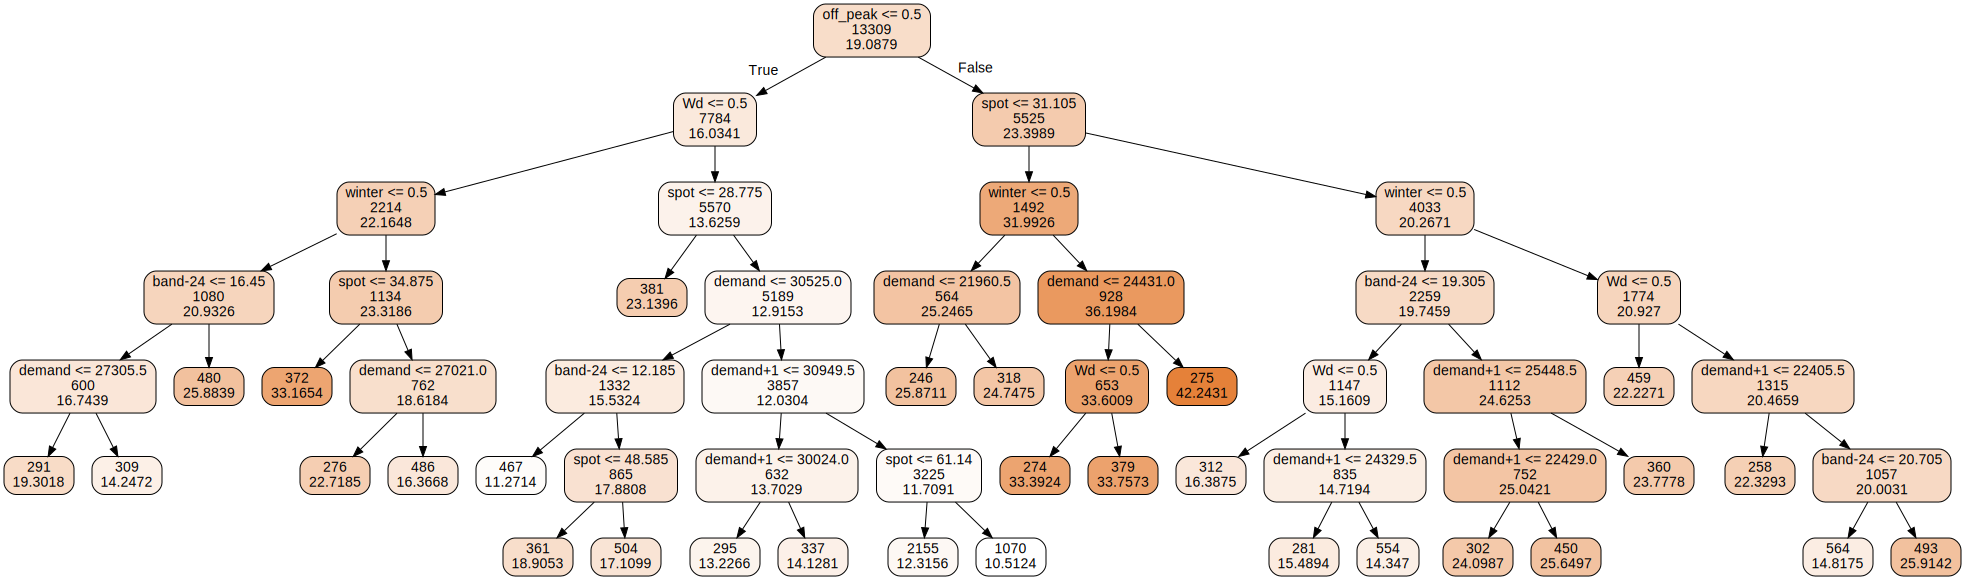

In [91]:
export_graphviz(rfr.estimators_[12], out_file="0.dot", max_depth=None, feature_names=features_list, label='none',
               filled=True, leaves_parallel=False, impurity=False, node_ids=False, proportion=False, rotate=False,
               rounded=True, special_characters=False)
with open("0.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)